In [1]:
import sys
sys.path.append("..")

In [2]:
import default_config as cfg
import local_storage_config as storage_cfg

cfg.__dict__.update(storage_cfg.__dict__)

In [3]:
import dataset_functions
import models.six_stage_linear_model as model
import dataset_builder
import utils
import tensorflow as tf
import visualizations as v
import matplotlib.pyplot as plt



In [4]:
import numpy as np
def extract_single_paf(paf,idx):
    ldim=int(paf.shape[-1]/2)
    return np.stack([paf[...,idx],paf[...,idx+ldim]],axis=-1)

In [5]:
model_ds=model.ModelDatasetComponent(cfg)

tfrecord_files_train=dataset_builder.get_tfrecord_filenames(cfg.TRAIN_TFRECORDS,cfg)
tfrecord_files_valid=dataset_builder.get_tfrecord_filenames(cfg.VALID_TFRECORDS,cfg)
tfrecord_files_train.sort()
tfrecord_files_valid.sort()
print("Found the following training TFrecords:\n","\n".join(tfrecord_files_train))
print("Found the following validation TFrecords:\n","\n".join(tfrecord_files_valid))

print("Building training dataset")

Retrieving TFrecords from: C:\Users\flash\Project\Yet-Another-Openpose-Implmentation/dataset/TFrecords/training
Retrieving TFrecords from: C:\Users\flash\Project\Yet-Another-Openpose-Implmentation/dataset/TFrecords/validation
Found the following training TFrecords:
 C:\Users\flash\Project\Yet-Another-Openpose-Implmentation/dataset/TFrecords\training-001.tfrecords
C:\Users\flash\Project\Yet-Another-Openpose-Implmentation/dataset/TFrecords\training-002.tfrecords
C:\Users\flash\Project\Yet-Another-Openpose-Implmentation/dataset/TFrecords\training-003.tfrecords
C:\Users\flash\Project\Yet-Another-Openpose-Implmentation/dataset/TFrecords\training-004.tfrecords
C:\Users\flash\Project\Yet-Another-Openpose-Implmentation/dataset/TFrecords\training-005.tfrecords
C:\Users\flash\Project\Yet-Another-Openpose-Implmentation/dataset/TFrecords\training-006.tfrecords
C:\Users\flash\Project\Yet-Another-Openpose-Implmentation/dataset/TFrecords\training-007.tfrecords
C:\Users\flash\Project\Yet-Another-Openp

In [6]:


def build_training_ds(tfrecord_filenames: list, labels_placement_function, config) -> tf.data.Dataset:
    """    :param config: effective config dict
    :param labels_placement_function: a model function, which applies the last stage of transformation to the dataset, to distribute the
    various labels correctly according to model outputs
    :param tfrecord_filenames: should be list of correct TFrecord filename, either local or remote (gcs, with gs:// prefix)"""
    # TFrecord files to raw format
    dataset_transformer = dataset_functions.DatasetTransformer(config)
    ds = tf.data.TFRecordDataset(tfrecord_filenames)  # numf reads can be put here, but I don't think I/O is the bottleneck

    # raw format to imgs,tensors(coords kpts)
    ds = ds.map(dataset_transformer.read_tfrecord)

    # cache  ,caching is here before decompressing jpgs and label tensors (should be ~9GB) , (full dataset should be ~90, cache later if RAM aviable)
    if config.CACHE: ds = ds.cache()
    #if config.SHUFFLE: ds = ds.shuffle(100)

    # Augmentation should be here, to operate on smaller tensors

    ds = ds.map(dataset_transformer.open_image) #jpeg to array
    ds = ds.map(dataset_transformer.make_label_tensors) # tensors to label_tensors (46,46,17/38)

    ds = ds.batch(config.BATCH_SIZE)

    #only image augmentation
    ds = ds.map(dataset_transformer.image_only_augmentation)
    ds = ds.map(dataset_transformer.mirror_augmentation)

    ds = ds.map(dataset_transformer.apply_mask)
    ds = ds.map(labels_placement_function) # imgs,label_tensors arrange for model outputs

    #ds = ds.repeat()
    #if config.PREFETCH: ds = ds.prefetch(config.PREFETCH)
    return ds

dsv=build_training_ds(tfrecord_files_valid,lambda x:x,cfg)
it=iter(dsv)



In [7]:
st=next(it)

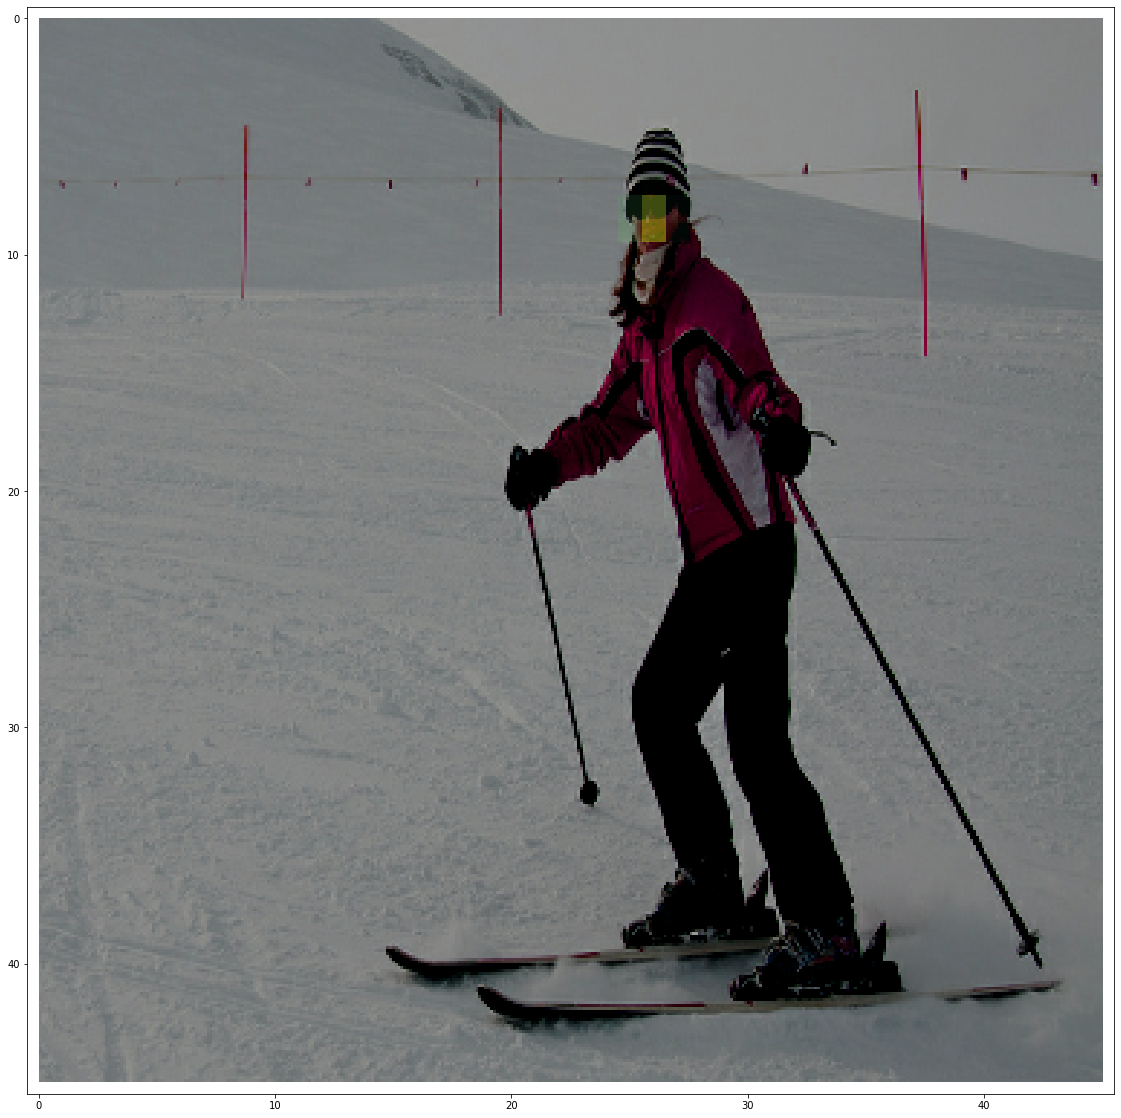

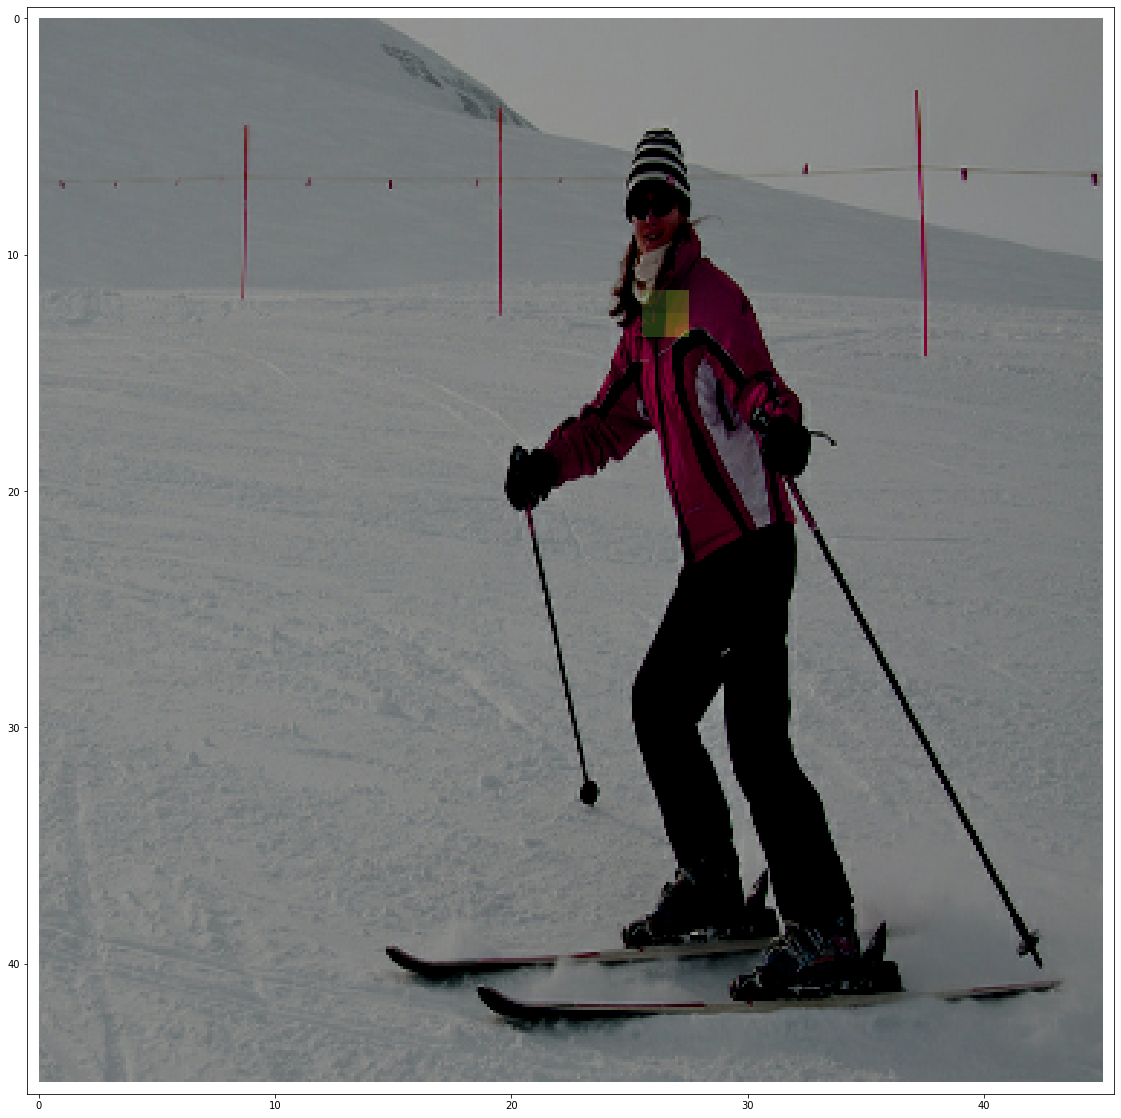

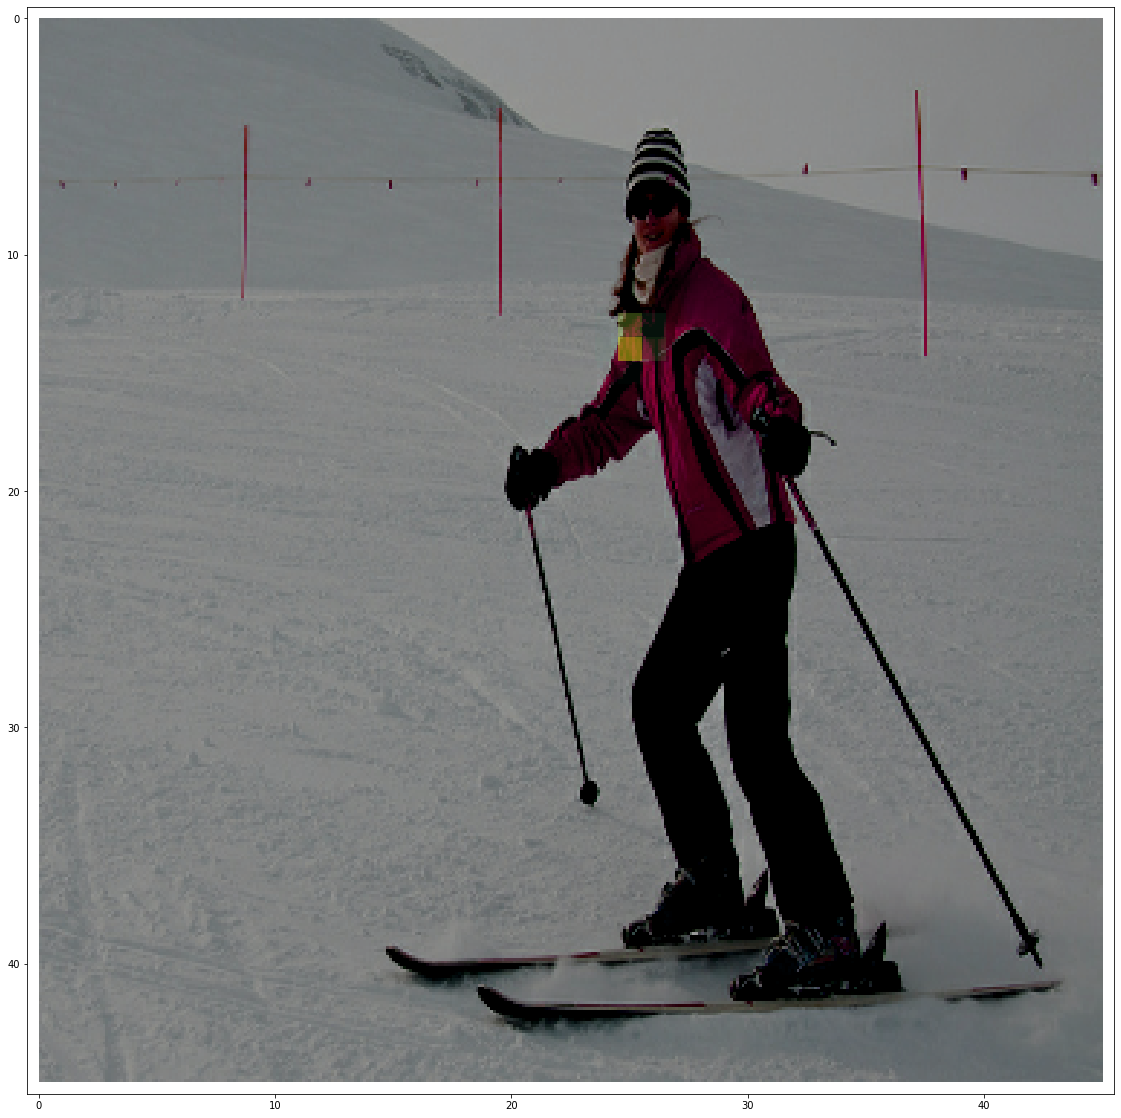

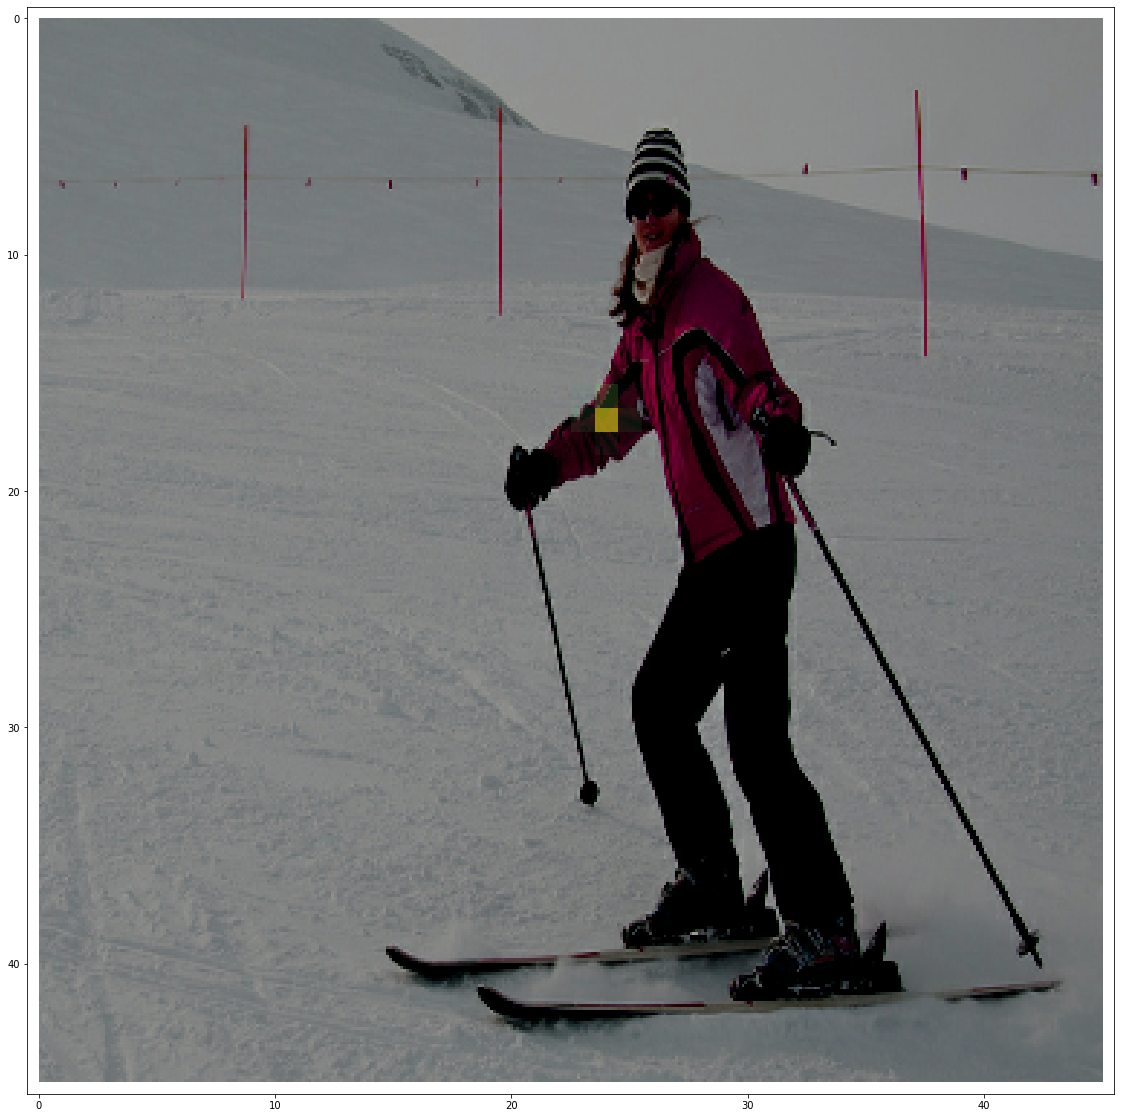

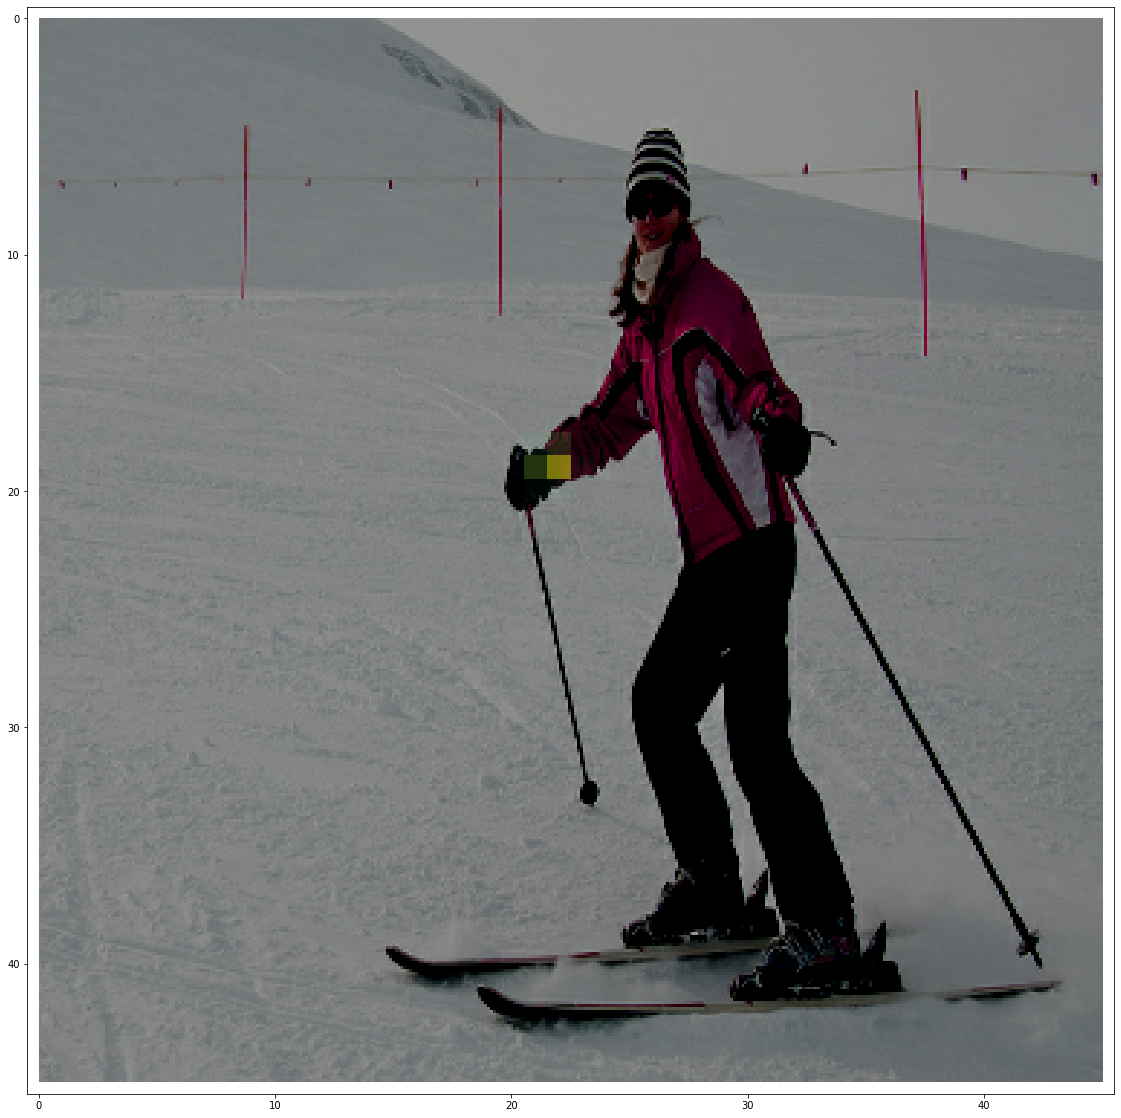

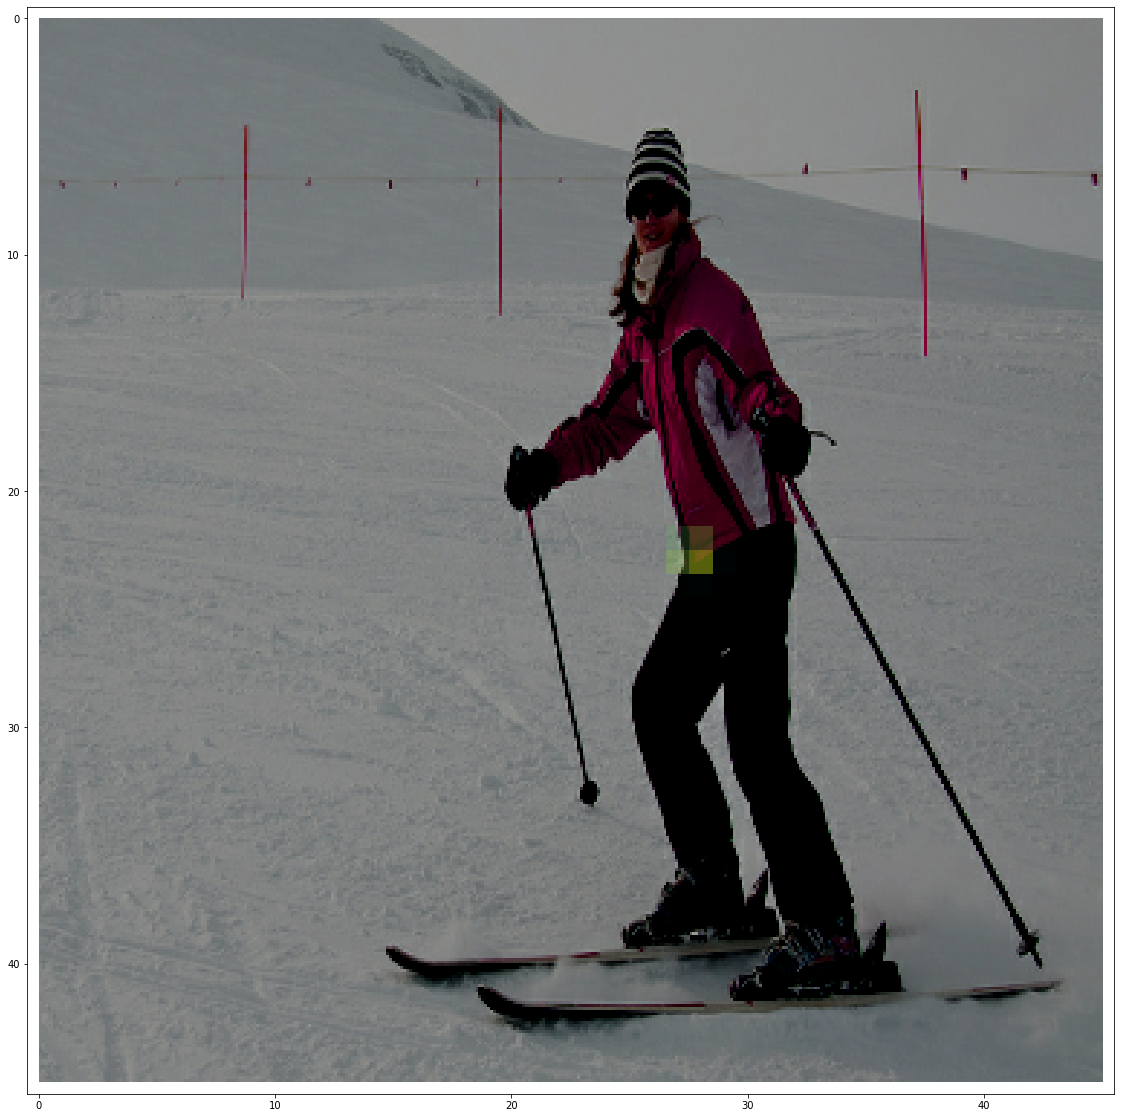

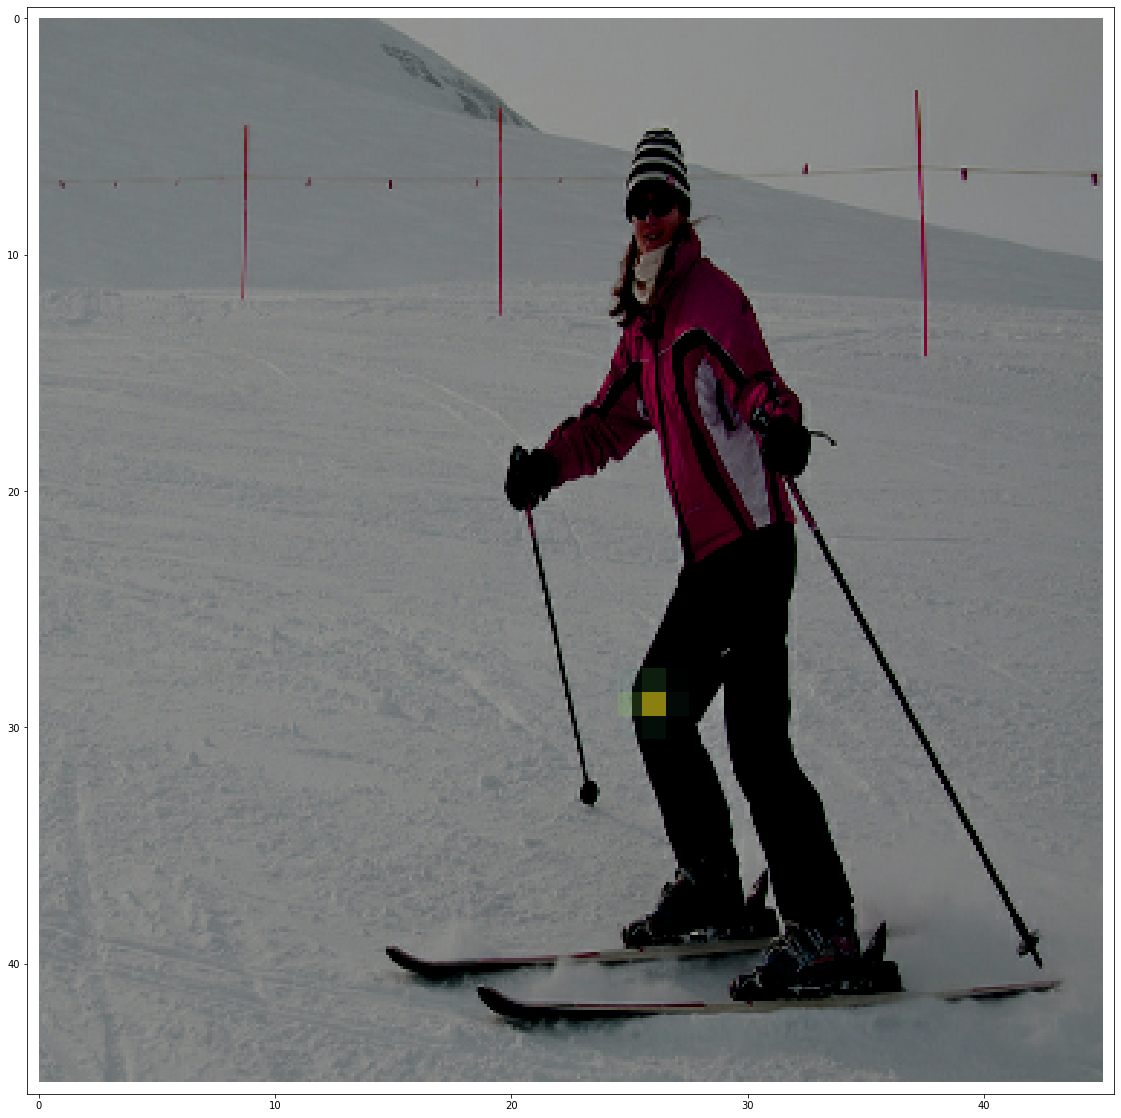

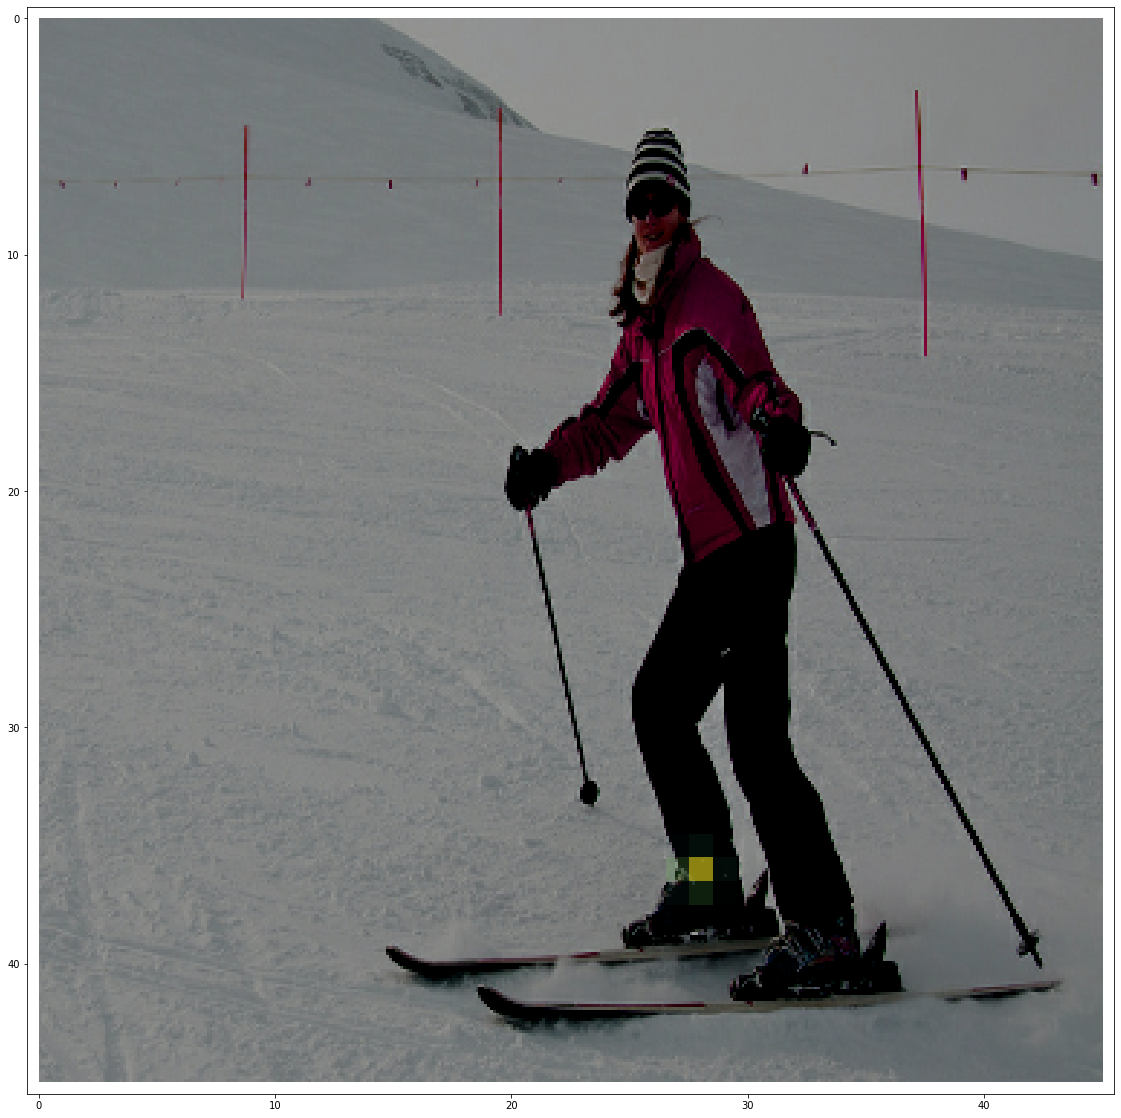

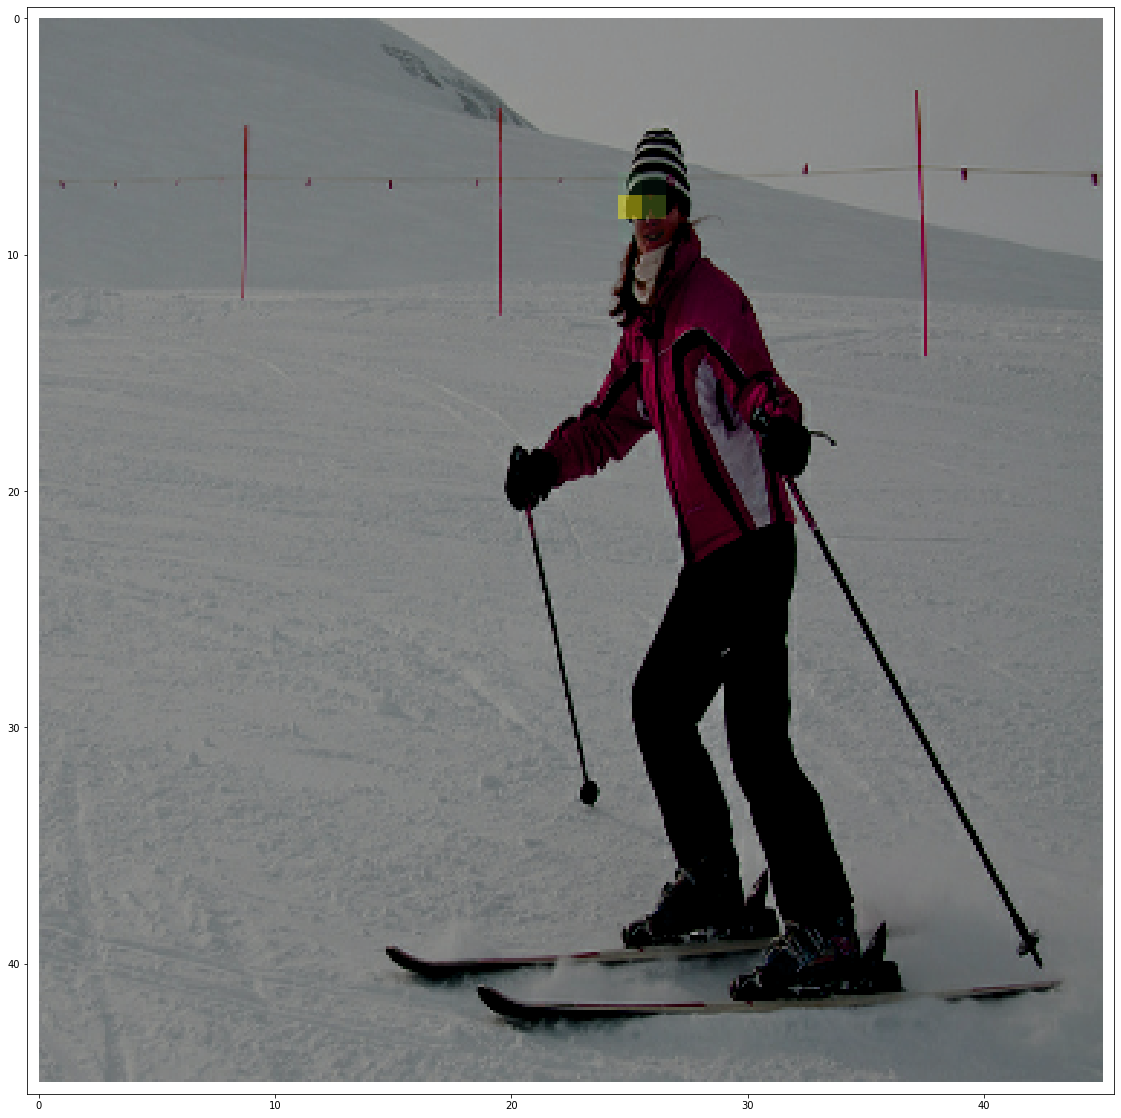

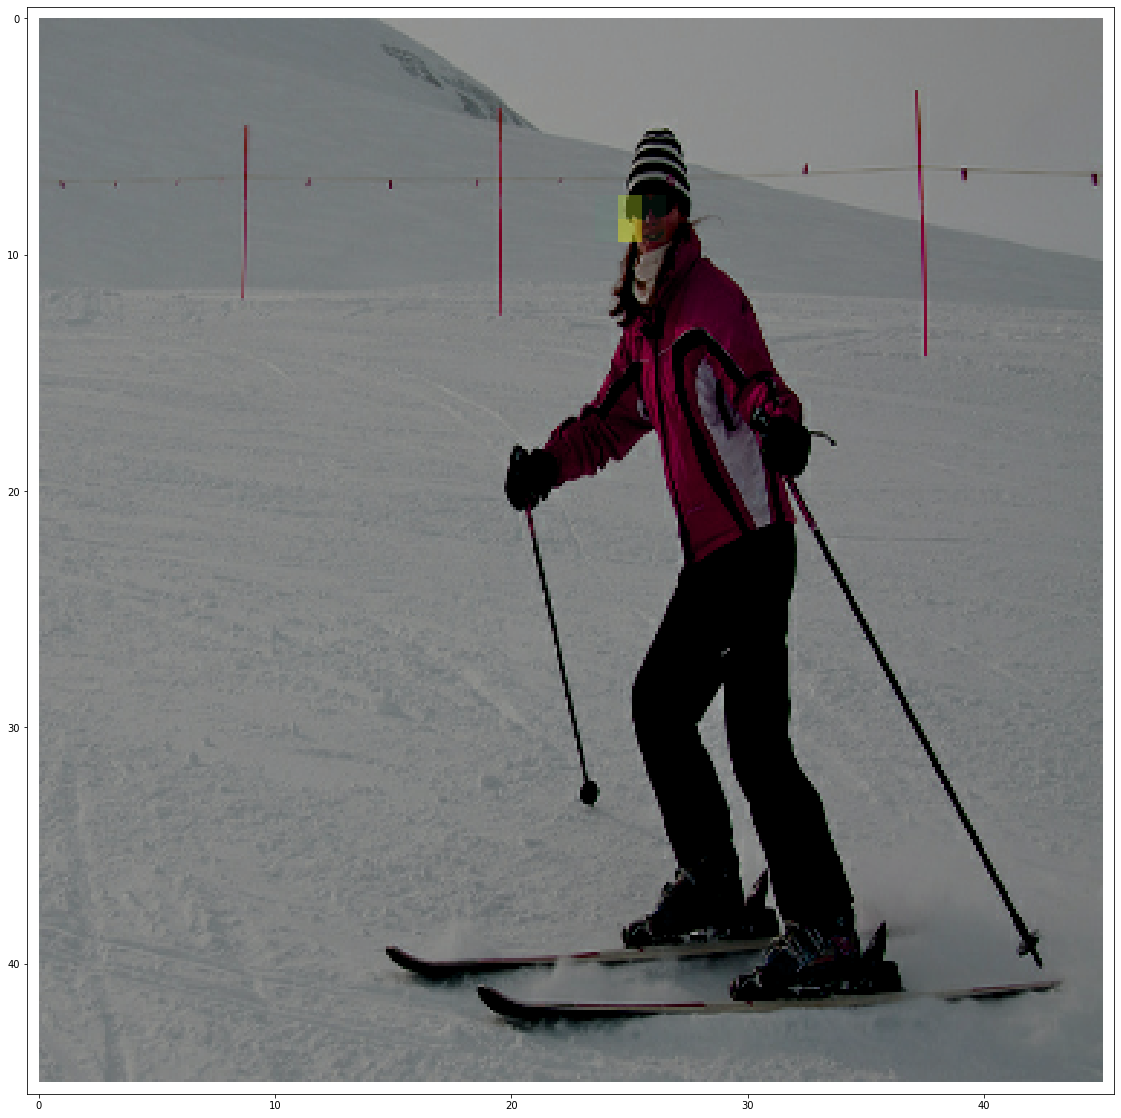

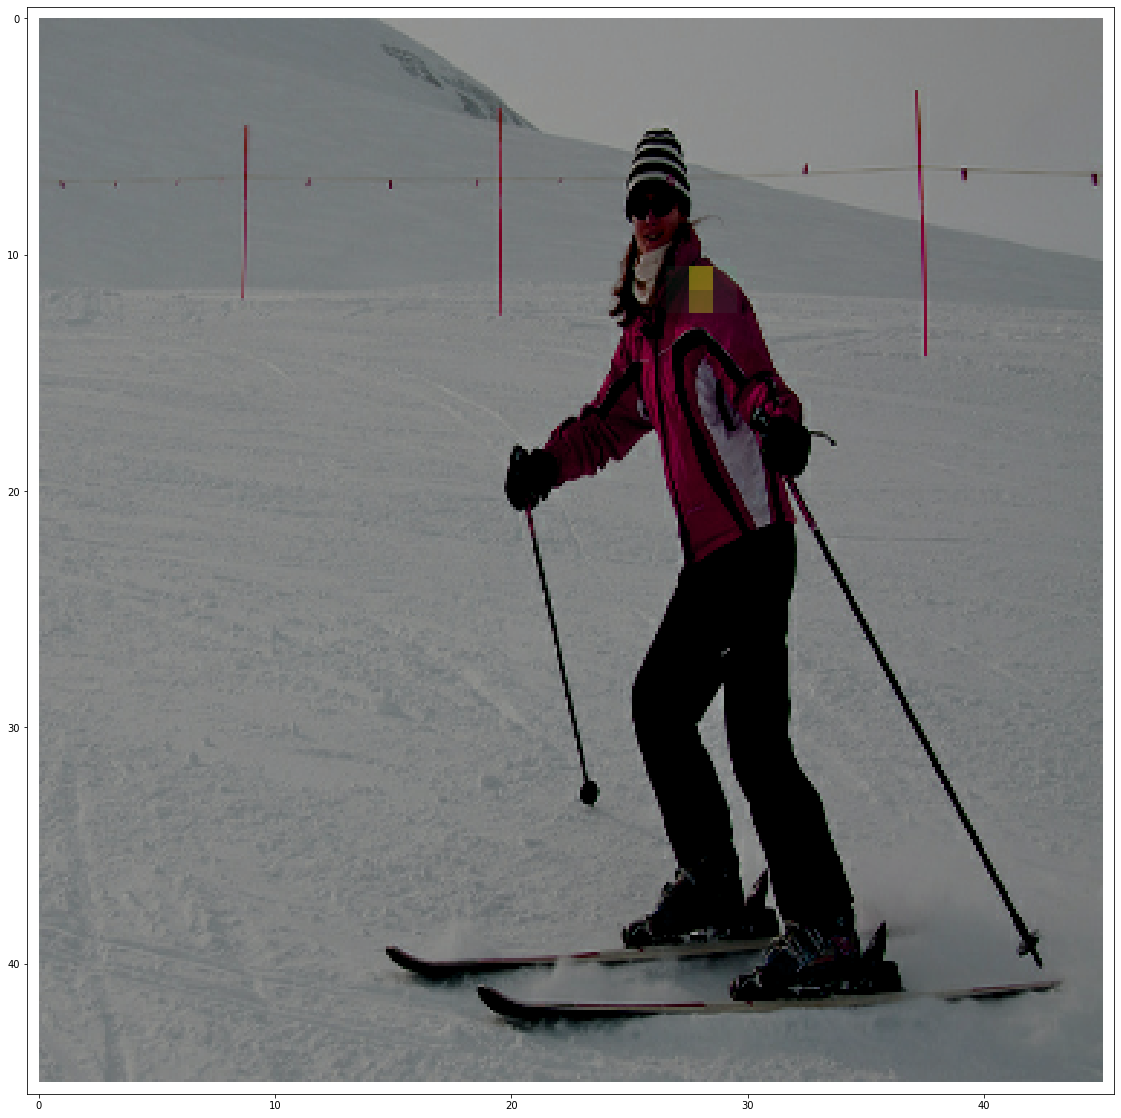

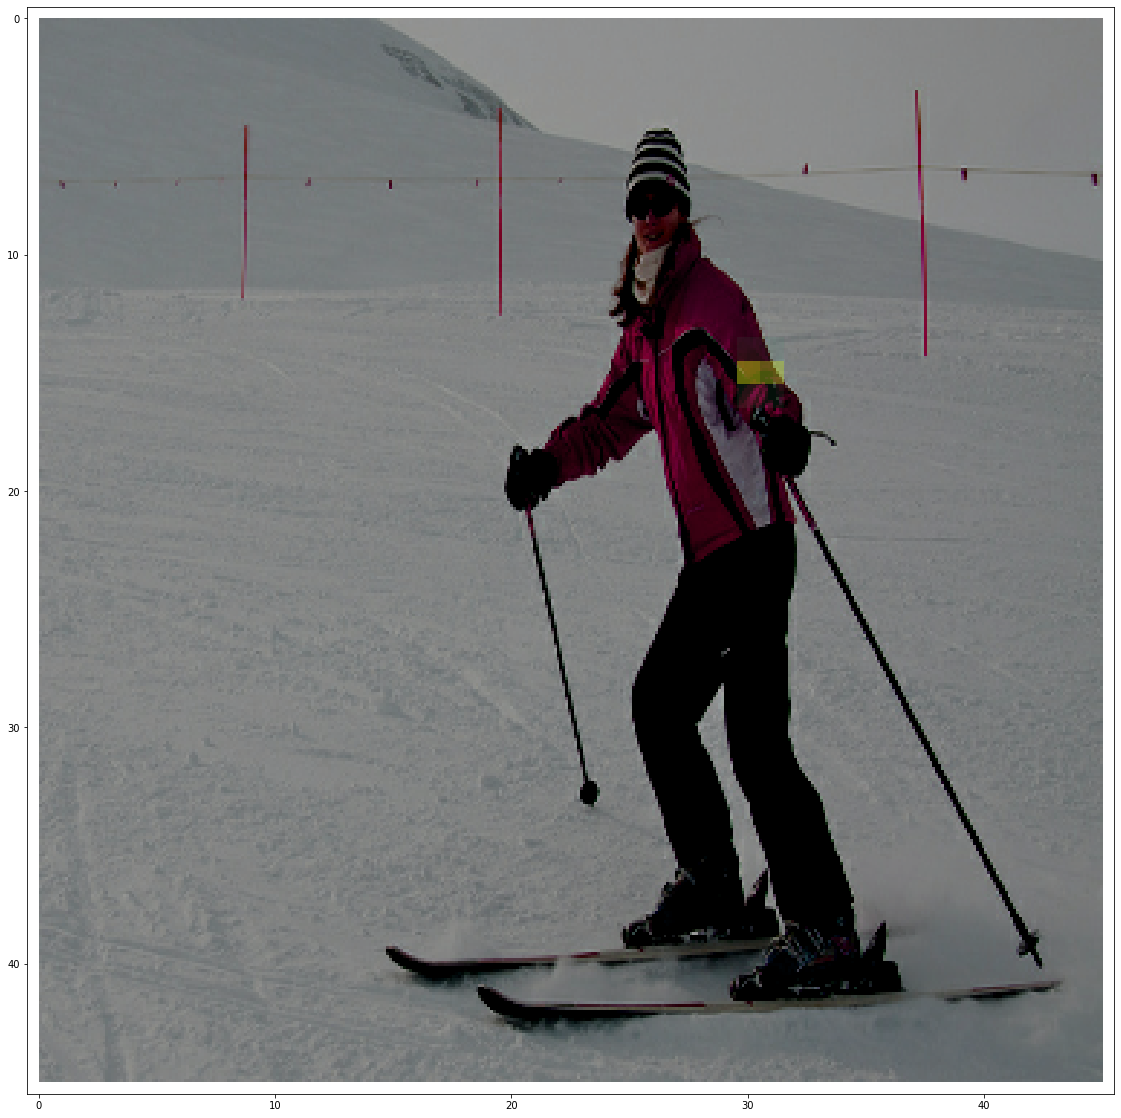

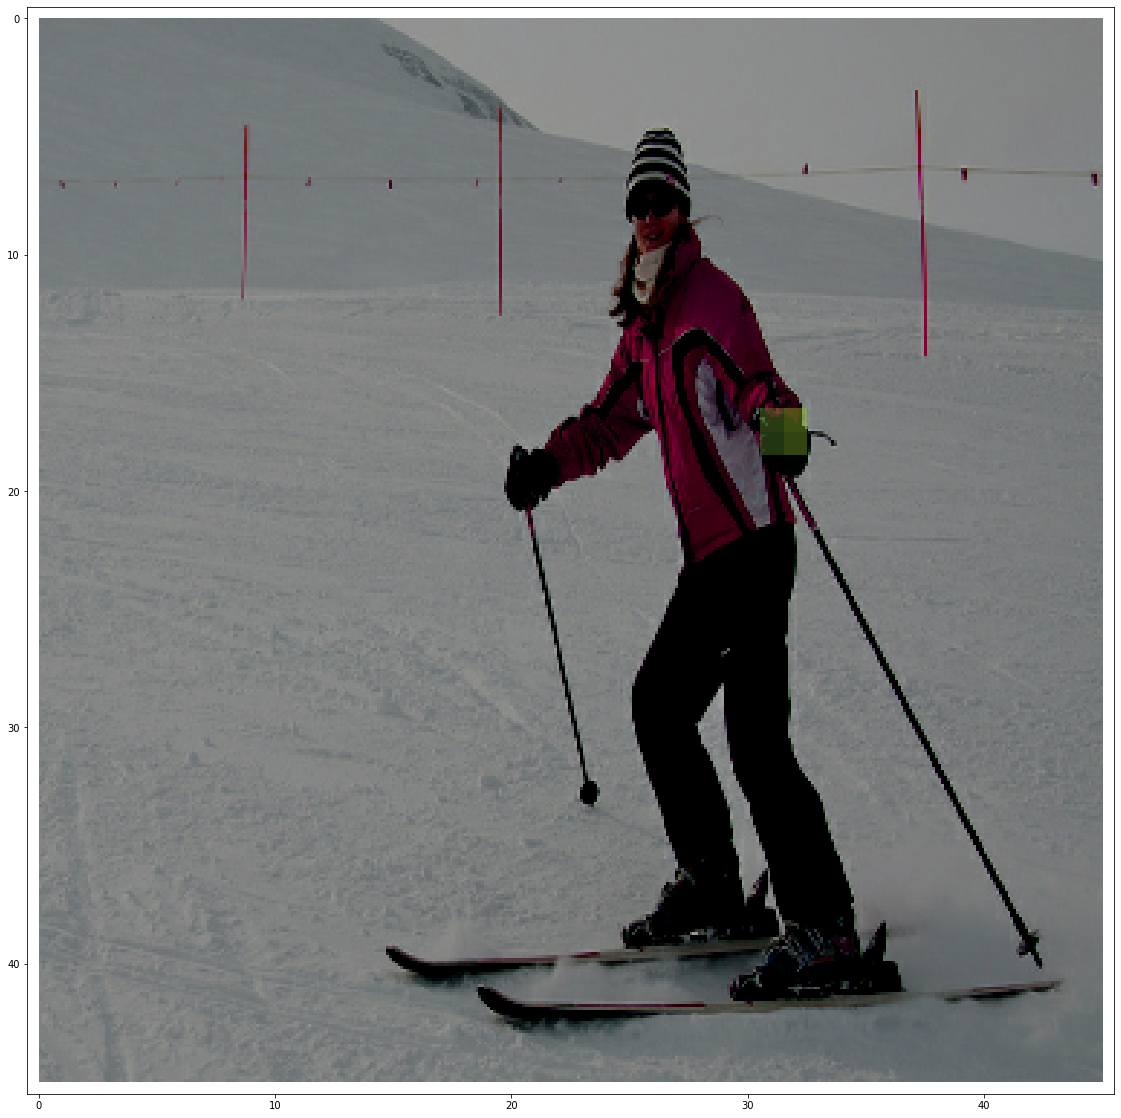

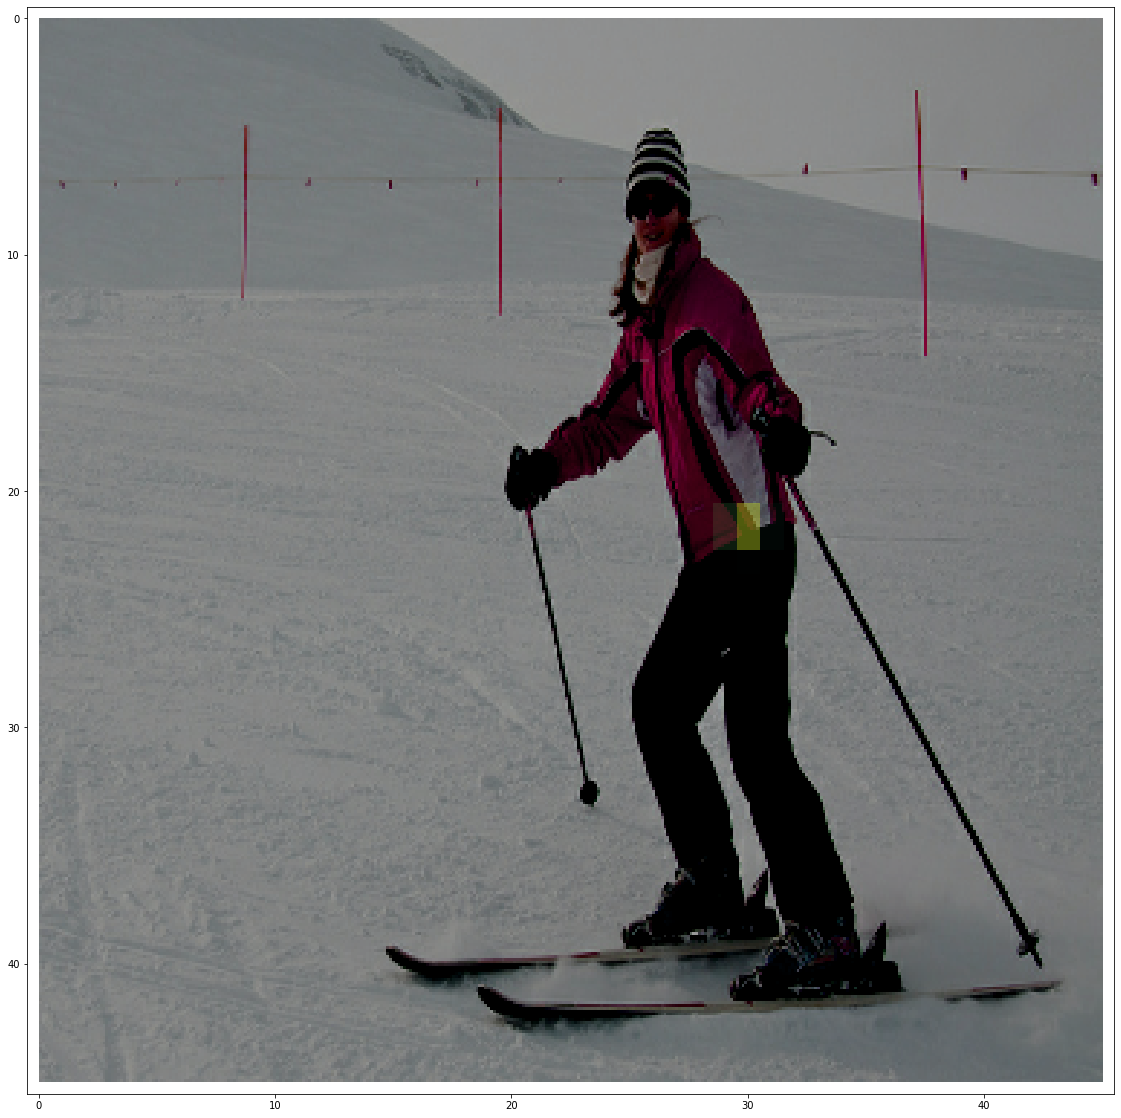

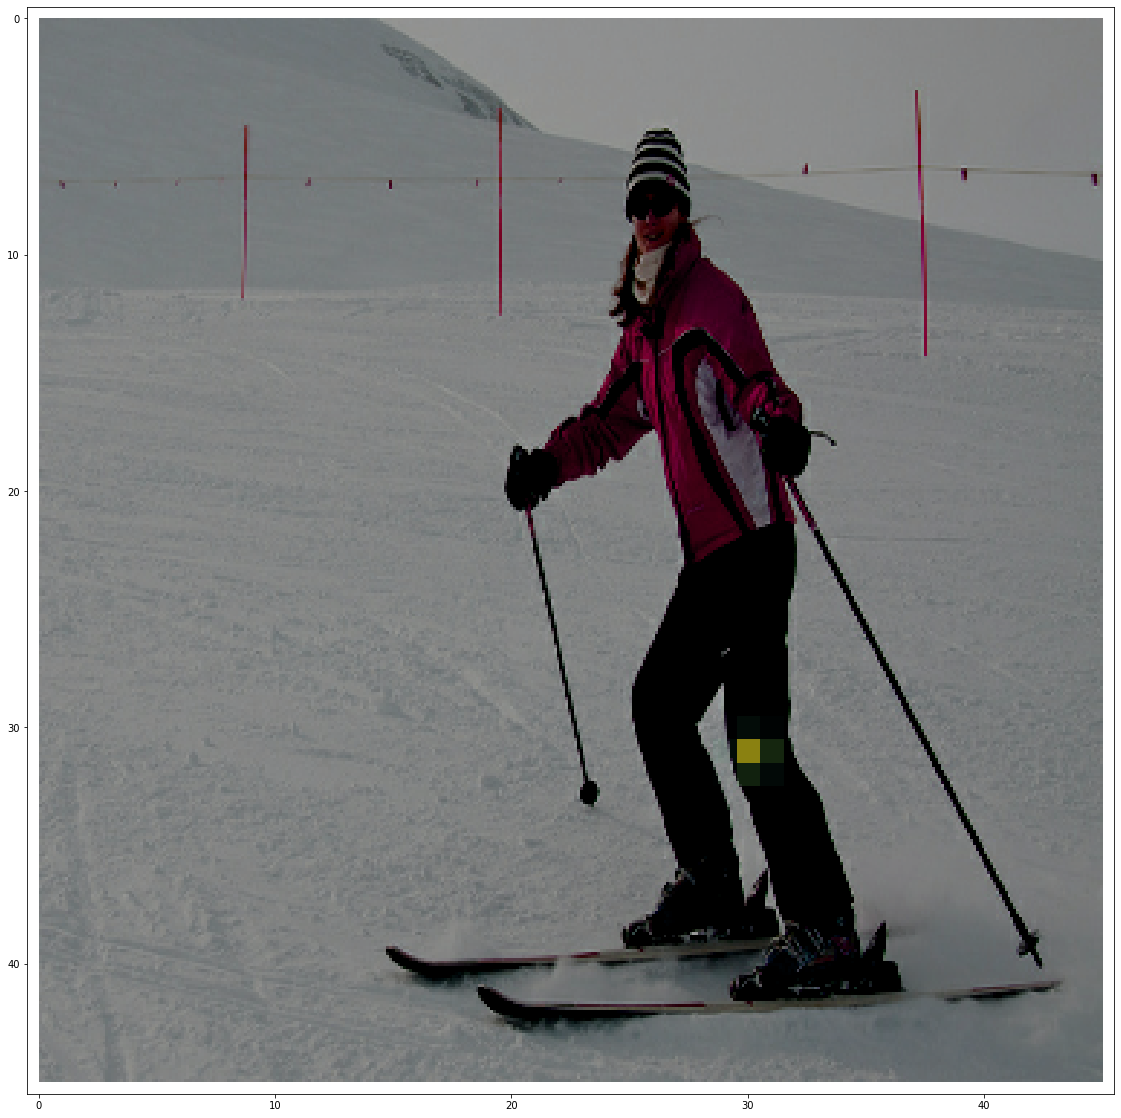

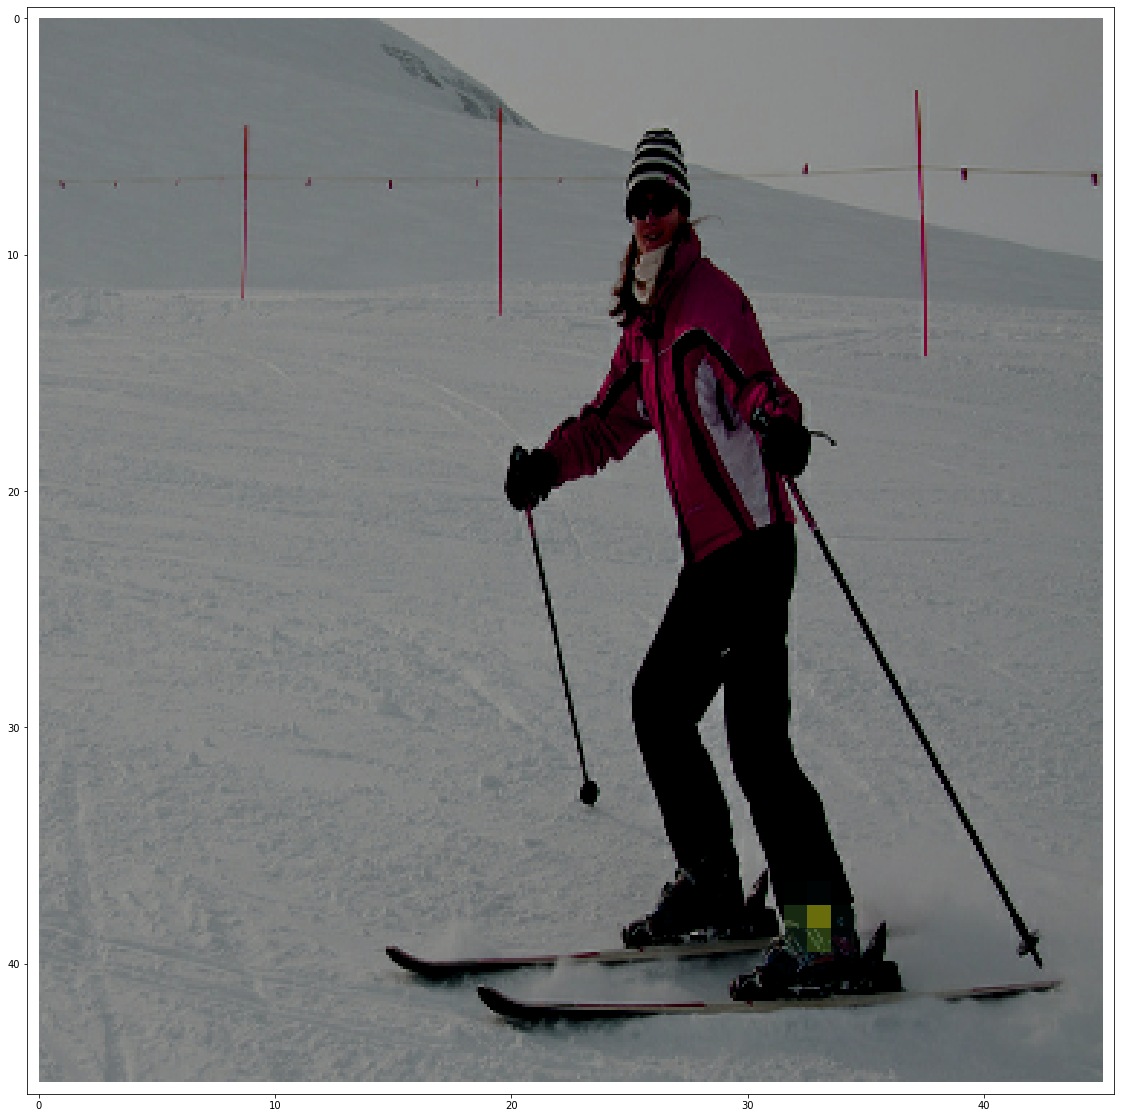

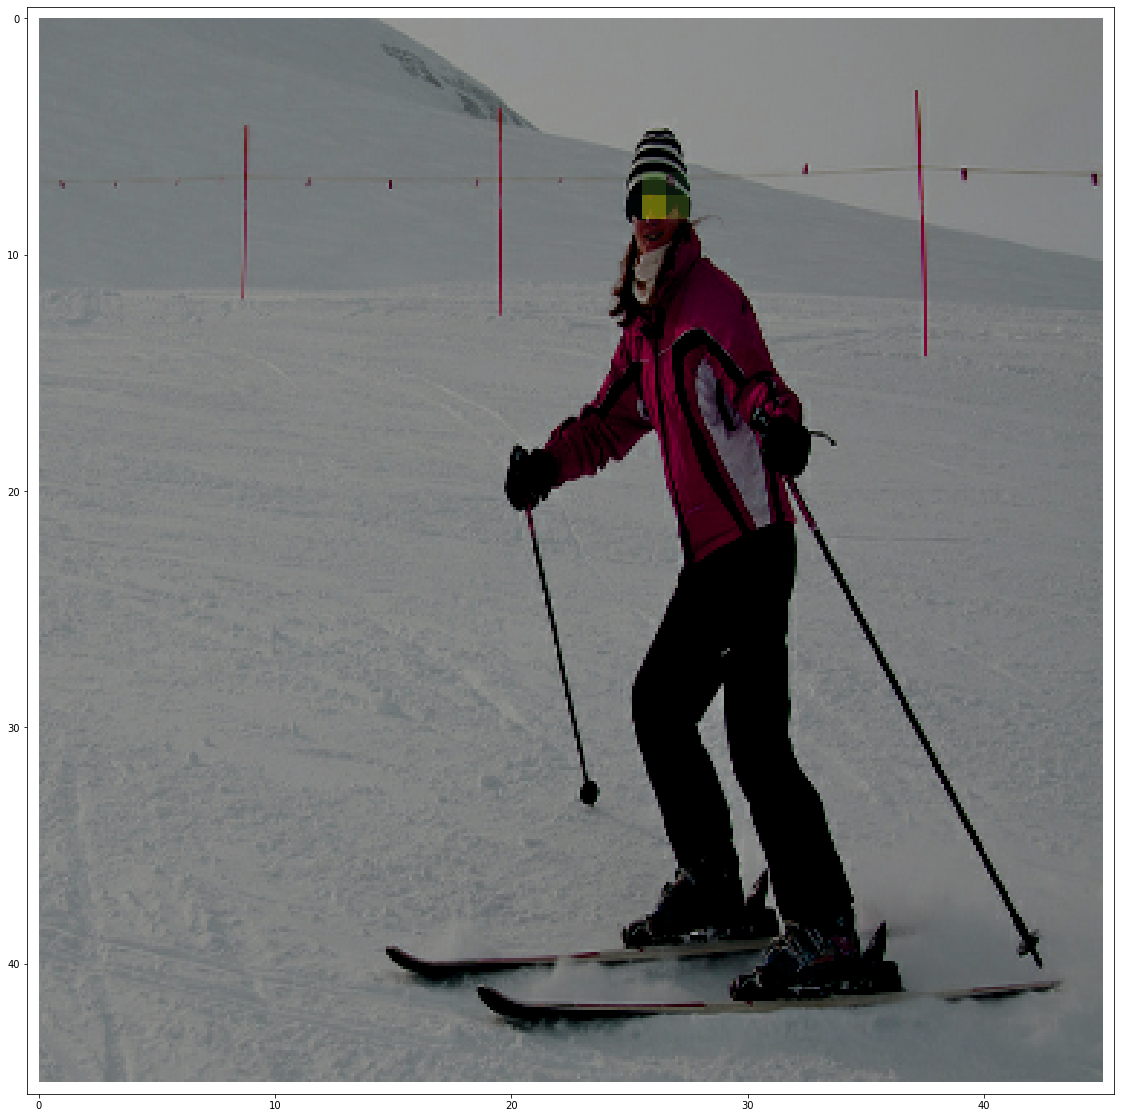

IndexError: index 34 is out of bounds for axis 2 with size 34

In [8]:
for x in range(18):
    img=st["image"][1].numpy()
    mask=st["pafs"][1][...,-1].numpy()
    pafs=st["pafs"][1][...,:-1].numpy()
    kpts=st["kpts"][1][...,:-1].numpy()
    paf=extract_single_paf(pafs,x)
    kpt=kpts[...,x:x+1]
    v.show_img_pafs_kpts(img,None,kpt,mask,figure_size=20)
    plt.show()

In [ ]:
for x in range(17):
    img=st["image"][1].numpy()
    mask=st["pafs"][1][...,-1].numpy()
    pafs=st["pafs"][1][...,:-1].numpy()
    kpts=st["kpts"][1][...,:-1].numpy()
    paf=extract_single_paf(pafs,x)
    kpt=kpts[...,x:x+1]
    v.show_img_pafs_kpts(img,paf,None,mask,figure_size=20)
    plt.show()

In [ ]:
#The error is mirroring the labels and switching them inadverntly



